In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os
import math as m

os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

print(tf.__version__)

2.1.0


In [20]:
df_sig = pd.read_csv("ROOT/pp_bbxaa/sig-kin.csv")
n_sig = len(df_sig)
weight_sig = int(round(np.mean(df_sig.pop('weight').to_numpy()) * 3 * 10e6 * n_sig))
df_sig_test = df_sig.sample(frac=0.2).reset_index(drop=True)
df_sig.drop(df_sig_test.index, inplace=True)

df_bkg = pd.read_csv("ROOT/pp_bbxaa/bkg-kin.csv")
n_bkg = len(df_bkg)
weight_bkg = int(round(np.mean(df_bkg.pop('weight').to_numpy()) * 3 * 10e6 * n_bkg))
df_bkg_test = df_bkg.sample(frac=0.2).reset_index(drop=True)
df_bkg.drop(df_bkg_test.index, inplace=True)

df_train = pd.concat([df_sig,df_bkg], ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [21]:

def runBDT(df, rf=False):
    X = df.drop(columns=['class'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=None)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    """ Fit the decision tree
    """
    if rf: classifier = ensemble.RandomForestClassifier(max_depth=5, n_estimators=10, criterion='gini')
    else: classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.02, objective='multi:softprob', num_class=2, 
                                         n_jobs=16, subsample=0.2, colsample_bytree=1, n_estimators=500)
    
    classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set, 
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    
    X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class']).columns)
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_shap)
    # shap.summary_plot(shap_values, X_shap, plot_type='violin')
    shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=["bkg", "sig"], class_inds='original')
    return classifier, x_test, y_test


Accuracy Score: 98.05% 


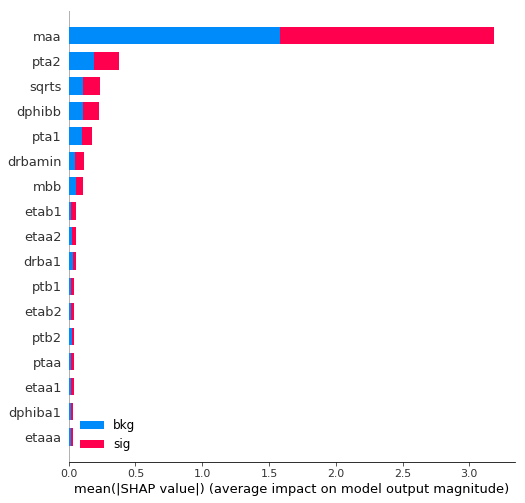

In [22]:
classifier, x_test, y_test = runBDT(df_train, rf=False)

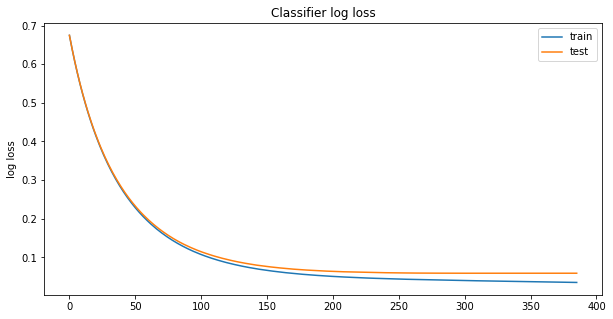

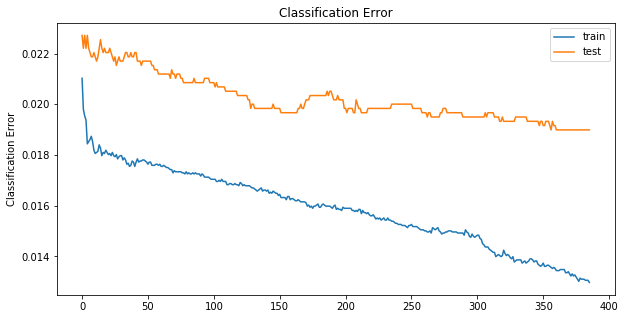

In [23]:
results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='test')
ax.legend()
    
plt.ylabel('log loss')
plt.title('Classifier log loss')
plt.show()
    

# plot classification error
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['merror'], label='train')
ax.plot(x_axis, results['validation_1']['merror'], label='test')
ax.legend()

plt.ylabel('Classification Error')
plt.title('Classification Error')
plt.show()

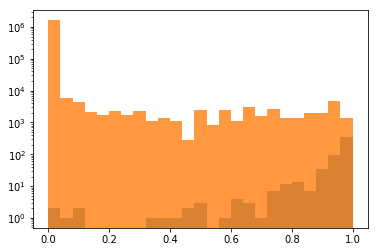

In [24]:
signal_pred = pd.DataFrame(classifier.predict_proba(df_sig_test.drop(columns=['class']).values)[:,1])
background_pred = pd.DataFrame(classifier.predict_proba(df_bkg_test.drop(columns=['class']).values)[:,1])

signal_pred = signal_pred.sample(n=weight_sig).reset_index(drop=True)
background_pred = background_pred.sample(n=weight_bkg, replace=True).reset_index(drop=True)

sns.distplot(signal_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8})
sns.distplot(background_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8})
plt.yscale('log')

In [25]:
bdt_n_sig = signal_pred.loc[signal_pred.iloc[:,-1] > 0.98].shape[0]
bdt_n_bkg = background_pred.loc[background_pred.iloc[:,-1] > 0.98].shape[0]
bdt_n_sig/m.sqrt(bdt_n_sig + bdt_n_bkg)
print(bdt_n_sig, "signal events.", bdt_n_bkg, "background event.")
print("sig/sqrt(sig+bkg): ",bdt_n_sig/m.sqrt(bdt_n_sig + bdt_n_bkg))

255 signal events. 540 background event.
sig/sqrt(sig+bkg):  9.043918002181835


In [26]:
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 50 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=200):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/100.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                print('\nbaseline increased since learning times is approaching death')
                
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.ylim([0.8, 1])
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
    

In [43]:
def build_model(df):
    """ Build the model, define the optimizer and compile the model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(17, activation='linear', input_shape=[len(df.keys())-1]),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [44]:
model = build_model(df_sig)
model.summary()    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_11 (Dense)             (None, 24)                432       
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_13 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 50        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [48]:
# learning_rate = 0.003
EPOCHS = 20000
patience = 50
df_train_set = df_train.copy(deep=True)
df_train_labels = df_train_set.pop('class')

""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=320,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])

""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])

loss, accuracy = model.evaluate(df_sig_test.iloc[:,:-1], df_sig_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for signal: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_bkg_test.iloc[:,:-1], df_bkg_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for background: {:4.2f}%".format(accuracy*100))


 epochs =  0  val_loss =  0.0907858829565787
************************************************** epochs =  50  val_loss =  0.07903825335999043
************************************************** epochs =  100  val_loss =  0.0780202287547183
************************************************** epochs =  150  val_loss =  0.07859016619818476
************************************************** epochs =  200  val_loss =  0.07921364186936303
*****
baseline increased since learning times is approaching death
********************************************* epochs =  250  val_loss =  0.07420348249228047
******************************
baseline increased since learning times is approaching death
******************** epochs =  300  val_loss =  0.07550887502938292
*****
baseline increased since learning times is approaching death
*************************
baseline increased since learning times is approaching death
******************** epochs =  350  val_loss =  0.08295182656142484
*****
baseline increase

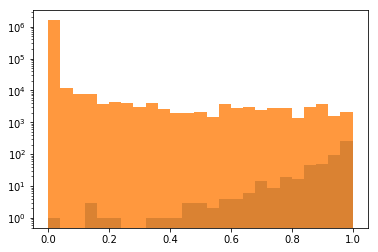

In [49]:
test_predictions_sig = model.predict(df_sig_test.sample(n=weight_sig).reset_index(drop=True).iloc[:,:-1])[:,1]
test_predictions_bkg = model.predict(df_bkg_test.sample(n=weight_bkg, replace=True).reset_index(drop=True).iloc[:,:-1])[:,1]


plt.figure()
plt.hist(test_predictions_sig, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8)
plt.hist(test_predictions_bkg, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8)
plt.yscale('log')

In [52]:
NN_n_sig = len(np.where(test_predictions_sig > 0.98)[0])
NN_n_bkg = len(np.where(test_predictions_bkg > 0.98)[0])
print(NN_n_sig, "signal events.", NN_n_bkg, "background event.")
print("sig/sqrt(sig+bkg): ",NN_n_sig/m.sqrt(NN_n_sig + NN_n_bkg))

165 signal events. 831 background event.
sig/sqrt(sig+bkg):  5.228225066826943


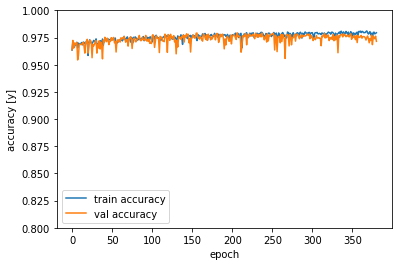

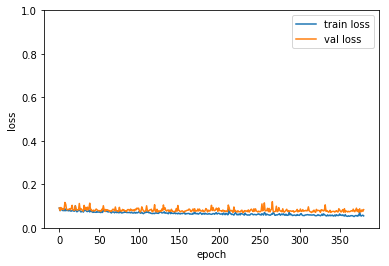

In [53]:
plot_history(history)